In [1]:
import urllib.request
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch
import torch.nn as nn
import time
from torch.utils.data import Dataset, DataLoader

In [2]:
module_path = "..."
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from script import data_utils, helper_utils

In [4]:
data_path = module_path + '/data/ml-100k/'
delimiter ='\t'
col_names=['user_id', 'item_id', 'rating', 'timestamp']
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'  

# Hyper parameters
num_epochs = 5
batch_size = 256
lr = 0.002
num_factors = 30
wd=1e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
data, num_users, num_items, sparsity = data_utils.read_data_ml100k(data_path, delimiter, col_names, url)

train_data, test_data = data_utils.split_data(data, num_users, num_items, split_mode='seq-aware', test_ratio=0.1)

train_users, train_items, train_scores, train_inter = data_utils.load_data(train_data, num_users, num_items, feedback='explicit')

test_users, test_items, test_scores, test_inter = data_utils.load_data(test_data, num_users, num_items, feedback='explicit')

number of users: 943, number of items: 1682
matrix sparsity: 0.936953


In [25]:
train_inter.shape

(1682, 943)

In [7]:
class MyData(Dataset):
    def __init__(self, user, item, score):
        self.user = torch.tensor(user)
        self.item = torch.tensor(item)
        self.score = torch.tensor(score)
        
    def __getitem__(self, index):
        return (self.user[index], self.item[index], self.score[index])
    
    def __len__(self):
        return len(self.score)

In [8]:
# Create Dataset
train_set = MyData(np.array(train_users), np.array(train_items), np.array(train_scores))
test_set = MyData(np.array(test_users), np.array(test_items), np.array(test_scores))

In [9]:
# Create Dataloader
train_iter = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_iter = DataLoader(test_set, batch_size=batch_size)

In [10]:
#iter(train_iter).next()

In [11]:
start = time.time()
class MF(nn.Module):
    def __init__(self, num_factors, num_users, num_items):
        super(MF, self).__init__()
        self.user_factors = nn.Embedding(num_users, num_factors)
        self.item_factors = nn.Embedding(num_items, num_factors)
        
        nn.init.normal_(self.user_factors.weight, std=0.01)
        nn.init.normal_(self.item_factors.weight, std=0.01)
        
    def forward(self, user, item):
        return ((self.user_factors(user) * self.item_factors(item)).sum(axis=1))
    
    def predict(self, user, item):
        return self.forward(user, item)
    
model = MF(num_factors, num_users, num_items).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

# Train the Model
train_rmse = []
test_rmse = []
test_score_val = []
test_score_pred = []
for epoch in range(num_epochs):
    train_loss = 0
    num_train = 0
    model.train()
    for users, items, scores in train_iter:
        users = users.to(device)
        items = items.to(device)
        scores = scores.float().to(device)

        # Forward pass
        outputs = model(users, items)
        loss = criterion(outputs, scores)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        num_train += 1
        
    train_rmse.append(train_loss / num_train)
    
    model.eval()
    test_loss = 0
    num_test = 0
    with torch.no_grad():
        for users, items, scores in test_iter:
            users = users.to(device)
            items = items.to(device)
            scores = scores.float().to(device)

            outputs = model(users, items)
            loss = criterion(outputs, scores)
            
            test_score_val.append(scores)
            test_score_pred.append(outputs)
            
            test_loss += loss.item()
            num_test += 1
    
    test_rmse.append(test_loss / num_test)
end = time.time()
print(end-start)

9.98826265335083


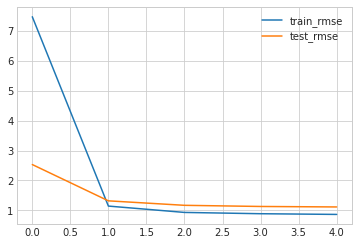

In [12]:
gain = 1
helper_utils.plot_error([x*gain for x in train_rmse], test_rmse, num_epochs)

In [13]:
score_df = pd.concat([pd.Series([i for sublist in [x.tolist() for x in test_score_pred] for i in sublist ], name='pred')
                      , pd.Series([i for sublist in [x.tolist() for x in test_score_val] for i in sublist ], name='value')], axis=1)

In [ ]:
len([i for sublist in [x.tolist() for x in test_score_pred] for i in sublist ])

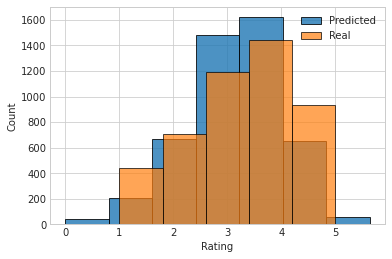

In [14]:
plt.hist(score_df['pred'], bins=7, ec='black', alpha=0.8, label = 'Predicted')
plt.hist(score_df['value'], bins=5, ec='black', alpha=0.7, label = 'Real')
plt.xlabel('Rating')
plt.ylabel('Count')
#plt.title('Distribution of Ratings in MovieLens 100K')
plt.legend()
plt.show()

In [15]:
model.predict(torch.tensor([1]).to(device),torch.tensor([1]).to(device))

tensor([3.3067], device='cuda:0', grad_fn=<SumBackward1>)

In [17]:
score_df['diff'] = score_df.apply(lambda x: x.value - x.pred if x.value is not np.nan else 0, axis=1)

(array([  66.,  460., 1396., 1737.,  821.,  193.,   42.]),
 array([-3.50392008, -2.35775186, -1.21158365, -0.06541543,  1.08075278,
         2.226921  ,  3.37308921,  4.51925743]),
 <BarContainer object of 7 artists>)

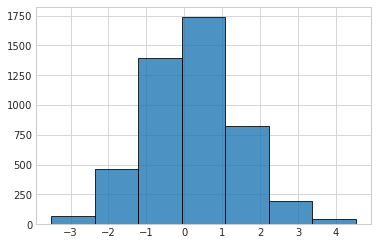

In [19]:
plt.hist(score_df['diff'], bins=7, ec='black', alpha=0.8, label = 'Predicted')